In [63]:
import re
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from joblib import parallel_backend
from networkx.algorithms.community import girvan_newman
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    adjusted_rand_score,
    classification_report,
    confusion_matrix,
    f1_score,
    normalized_mutual_info_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Part 1

## Data Load

In [40]:
# Define the column names
tweets_column_names = [
    "username",
    "user_handle",
    "user_id",
    "statuses_count",
    "followers_count",
    "location",
    "bio",
    "created_at",
    "tweet_id",
    "language",
    "NaN",
    "retweet_count",
    "favorite_count",
    "text",
]

tweets = pd.read_csv(
    "clinton_trump_tweets.txt", sep="\t", header=None, encoding="latin1"
)

tweets.columns = tweets_column_names

In [41]:
# Define the column names
classes_column_names = ["user_id", "class"]

user_classes = pd.read_csv(
    "clinton_trump_user_classes.txt", sep="\t", header=None, names=classes_column_names
)

In [42]:
print("user classes df size: ", user_classes.shape)
print("tweets df size: ", tweets.shape)

user classes df size:  (200000, 2)
tweets df size:  (5250980, 14)


## Data Inspect

In [43]:
tweets.head(1)

username user_handle     user_id  statuses_count  followers_count  \
0    Cebel      Cebel6  1519696717             132              263   

                location                                                bio  \
0  Little Rock, Arkansas  Arkansas Razorback Fan Just trying to be #Unco...   

                      created_at            tweet_id language  NaN  \
0  Sat Oct 29 08:10:06 EEST 2016  792232017094119425       en  NaN   

   retweet_count  favorite_count  \
0              0               1   

                                                text  
0  @NWAJimmy I've read it now though brother. Was...

## Merge Datasets

In [44]:
# Merge the DataFrames on the 'user_id' column
merged_df = pd.merge(tweets, user_classes, on="user_id")

merged_df.shape

(5250980, 15)

In [45]:
original_df = merged_df.copy()
dataset = merged_df.copy()

## Merged Dataset Inspect

In [46]:
dataset.head(1)

username user_handle     user_id  statuses_count  followers_count  \
0    Cebel      Cebel6  1519696717             132              263   

                location                                                bio  \
0  Little Rock, Arkansas  Arkansas Razorback Fan Just trying to be #Unco...   

                      created_at            tweet_id language  NaN  \
0  Sat Oct 29 08:10:06 EEST 2016  792232017094119425       en  NaN   

   retweet_count  favorite_count  \
0              0               1   

                                                text  class  
0  @NWAJimmy I've read it now though brother. Was...      0

## Drop Columns

In [47]:
columns_to_drop = [
    "username",
    "user_handle",
    "user_id",
    "location",
    "bio",
    "created_at",
    "tweet_id",
    "language",
    "NaN",
    "text"
]

dataset = dataset.drop(columns=columns_to_drop)

In [48]:
print("Dataset size: ", dataset.shape)
dataset.tail(1)

Dataset size:  (5250980, 5)


statuses_count  followers_count  retweet_count  favorite_count  class
5250979               7               33          36695               0      0

## Drop users with less then 10 tweets

In [49]:
dataset = dataset.drop(dataset[dataset['statuses_count'] < 10].index)
dataset.shape

(5227504, 5)

In [50]:
dataset.tail(1)

statuses_count  followers_count  retweet_count  favorite_count  class
5250978            4849             2154              4              37      1

## Convert Dataset Dtypes

In [51]:
def convert_to_float(df):

    for column in df.columns:
        try:
            df[column] = df[column].astype(float)
        except ValueError:
            print(f"Unable to convert column '{column}' to float.")
    return df

dataset = convert_to_float(dataset)
print(dataset.dtypes)

statuses_count     float64
followers_count    float64
retweet_count      float64
favorite_count     float64
class              float64
dtype: object


## Dataset numerical columns inspection

In [52]:
dataset.describe()

statuses_count  followers_count  retweet_count  favorite_count  \
count    5.227504e+06     5.227504e+06   5.227504e+06    5.227504e+06   
mean     9.454445e+03     2.416198e+03   1.167563e+03    1.271841e+00   
std      1.187099e+05     1.755602e+04   7.678568e+03    4.252228e+01   
min      1.000000e+01     0.000000e+00   0.000000e+00    0.000000e+00   
25%      2.600000e+02     3.690000e+02   0.000000e+00    0.000000e+00   
50%      6.830000e+02     8.510000e+02   3.000000e+00    0.000000e+00   
75%      1.955000e+03     2.048000e+03   1.410000e+02    0.000000e+00   
max      1.370044e+07     1.152347e+06   3.303593e+06    2.793100e+04   

              class  
count  5.227504e+06  
mean   4.959137e-01  
std    4.999833e-01  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    1.000000e+00  
max    1.000000e+00

## Split train and test dataset

In [53]:
x = dataset.drop(columns = 'class')
y = dataset['class'].values
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)
dataset.shape

(5227504, 5)

## Decision Tree Classifier

In [54]:
# Create a pipeline with a scaler and a decision tree classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dtc', DecisionTreeClassifier())
])

# Perform cross-validation with parallel processing
with parallel_backend('loky', n_jobs=-1):
    decision_tree_score = cross_val_score(pipeline, train_x, train_y)

print("Cross-validation scores:", decision_tree_score)
print("Mean cross-validation score:", decision_tree_score.mean())

# Train the model using the pipeline with parallel processing
with parallel_backend('loky', n_jobs=-1):
    pipeline.fit(train_x, train_y)

# Test the model
y_pred = pipeline.predict(test_x)

# Calculate the test accuracy
test_accuracy = accuracy_score(test_y, y_pred)
print("DTC Test accuracy:", test_accuracy)

Cross-validation scores: [0.96734222 0.96769014 0.96695604 0.96809541 0.96641559]
Mean cross-validation score: 0.9672998799645145
DTC Test accuracy: 0.9707441695416839


## KNN

In [55]:
x = dataset.drop(columns = 'class')
y = dataset['class'].values
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)
dataset.shape

(5227504, 5)

In [56]:
# Create a pipeline with a scaler and a k-nearest neighbors classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

# Perform cross-validation with parallel processing
with parallel_backend('loky', n_jobs=-1):
    knn_model_score = cross_val_score(pipeline, train_x, train_y)

print("Cross-validation scores:", knn_model_score)
print("Mean cross-validation score:", knn_model_score.mean())

# Train the model using the pipeline with parallel processing
with parallel_backend('loky', n_jobs=-1):
    pipeline.fit(train_x, train_y)

# Test the model
y_pred = pipeline.predict(test_x)

# Calculate the test accuracy
test_accuracy = accuracy_score(test_y, y_pred)
print("KNN Test accuracy:", test_accuracy)

Cross-validation scores: [0.79952917 0.80088618 0.8001198  0.79958274 0.80030368]
Mean cross-validation score: 0.8000843135975252
KNN Test accuracy: 0.8095181161950108


## SVM

In [57]:
dataset50k = dataset.copy()
dataset50k = dataset50k[:50000]
x = dataset50k.drop(columns = 'class')
y = dataset50k['class'].values
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)
dataset50k.shape

(50000, 5)

In [58]:
# Create a pipeline with a scaler and a support vector classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Perform cross-validation with parallel processing
with parallel_backend('loky', n_jobs=-1):
    svm_model_score = cross_val_score(pipeline, train_x, train_y, cv=5)

print("Cross-validation scores:", svm_model_score)
print("Mean cross-validation score:", svm_model_score.mean())

# Train the model using the pipeline
pipeline.fit(train_x, train_y)

# Test the model
y_pred = pipeline.predict(test_x)

# Calculate the test accuracy
test_accuracy = accuracy_score(test_y, y_pred)
print("SVM Test accuracy:", test_accuracy)

Cross-validation scores: [0.573375 0.55     0.551375 0.55525  0.55375 ]
Mean cross-validation score: 0.55675
SVM Test accuracy: 0.5508


## Logistic Regression

In [61]:
x = dataset.drop(columns = 'class')
y = dataset['class'].values
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)
dataset.shape

(5227504, 5)

In [60]:
# Create a pipeline with a scaler and a logistic regression classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000))
])

# Perform cross-validation with parallel processing
with parallel_backend('loky', n_jobs=-1):
    lr_model_score = cross_val_score(pipeline, train_x, train_y, cv=5)

print("Cross-validation scores:", lr_model_score)
print("Mean cross-validation score:", lr_model_score.mean())

# Train the model using the pipeline with parallel processing
with parallel_backend('loky', n_jobs=-1):
    pipeline.fit(train_x, train_y)

# Test the model
y_pred = pipeline.predict(test_x)

# Calculate the test accuracy
test_accuracy = accuracy_score(test_y, y_pred)
print("LR Test accuracy:", test_accuracy)

Cross-validation scores: [0.51298958 0.51339489 0.51240852 0.51292683 0.51301769]
Mean cross-validation score: 0.5129475038754197
LR Test accuracy: 0.5133328423406577


# Part 2

## Dataset Load

In [95]:
network = original_df.copy()
retweets = network[["user_handle", "text","class"]]
retweets.head()
print("Data set size: ",retweets.shape)

Data set size:  (5250980, 3)


## Create Graph

In [96]:
G = nx.DiGraph()

with parallel_backend("loky", n_jobs=-1):
    for index, row in retweets.iterrows():
        retweet_text = row["text"]
        if retweet_text.startswith("RT @"):
            # Use regex to extract the user being retweeted
            match = re.search(r"@(\w+):", retweet_text)
            if match:
                retweet_user = match.group(1)
                user_handle = row["user_handle"]
                G.add_edge(user_handle, retweet_user)


edges_list = list(G.edges())
print(f"Number of edges: {len(edges_list)}")

Number of edges: 1871777


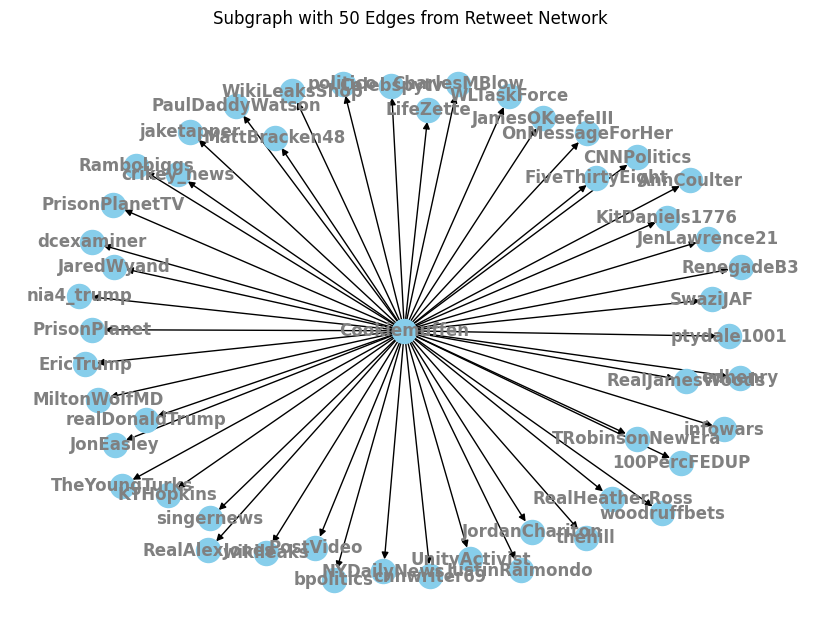

In [110]:
edges_to_draw = list(G.edges())[0:50]
subgraph = G.edge_subgraph(edges_to_draw).copy()

# Draw the subgraph
plt.figure(figsize=(8, 6))
nx.draw(subgraph, with_labels=True, node_size=300, node_color='skyblue', font_size=12, font_color='gray', font_weight='bold', arrowsize=10)
plt.title("Subgraph with 50 Edges from Retweet Network")
plt.show()

## Removing no tweets, Isolated Nodes

In [98]:
isolated_nodes = list(nx.isolates(G))
print("Isolated Nodes:", isolated_nodes)
G.remove_nodes_from(list(nx.isolates(G)))

Isolated Nodes: []


## Removing Nodes With Has Less than 10 Degree

In [99]:
edges_list = list(G.edges())
print(f"Before Removing Nodes Number of edges: {len(edges_list)}")

G_original = G.copy()

with parallel_backend("loky", n_jobs=-1):
    while True:
        nodes_to_remove = [node for node in G if G.degree(node) < 10]
        if not nodes_to_remove:
            break
        G.remove_nodes_from(nodes_to_remove)

edges_list = list(G.edges())
print(f"After Removing Nodes Number of edges: {len(edges_list)}")

Before Removing Nodes Number of edges: 1871777
After Removing Nodes Number of edges: 907889


## Finding Largest Connected Component

In [100]:
visited = set()
largest_component = set()

with parallel_backend("loky", n_jobs=-1):
    for node in G.nodes():
        if node not in visited:
            component = set(nx.dfs_tree(G, node).nodes())
            if len(component) > len(largest_component):
                largest_component = component
            visited.update(component)

G_largest = G.subgraph(largest_component).copy()

edges_list = list(G_largest.edges())
print(f"Largest Connected Component Number of edges: {len(edges_list)}")

Largest Connected Component Number of edges: 271415


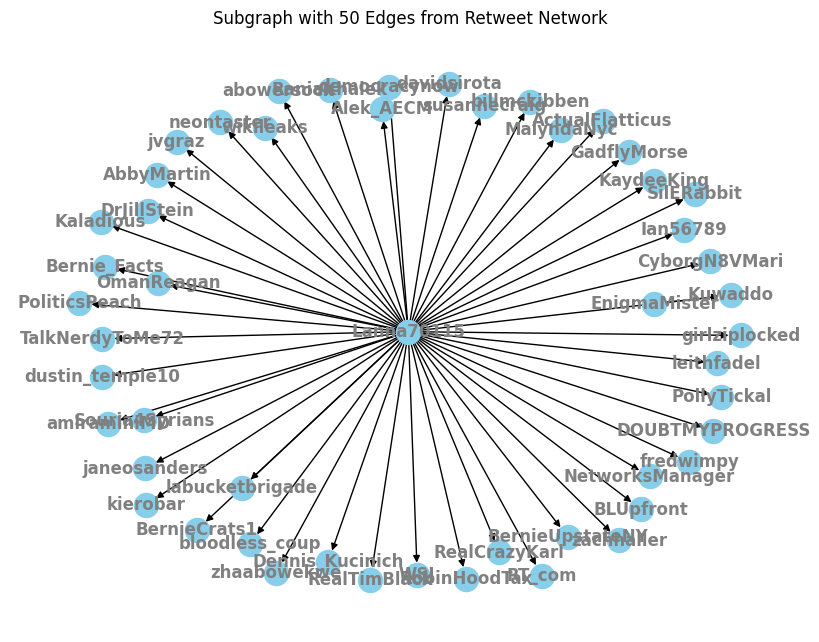

In [109]:
edges_to_draw = list(G_largest.edges())[0:50]
subgraph = G_largest.edge_subgraph(edges_to_draw).copy()

# Draw the subgraph
plt.figure(figsize=(8, 6))
nx.draw(subgraph, with_labels=True, node_size=300, node_color='skyblue', font_size=12, font_color='gray', font_weight='bold', arrowsize=10)
plt.title("Subgraph with 50 Edges from Retweet Network")
plt.show()

## Investigating class distributions in subgraph

In [102]:
subset = retweets[retweets["user_handle"].isin(G_largest.nodes)]
trump_count = subset[subset["class"] == 0]["user_handle"].nunique()
clinton_count = subset[subset["class"] == 1]["user_handle"].nunique()
# Calculate the total count
total_count = trump_count + clinton_count

print("Trump Followers Count:", trump_count / total_count)
print("Clinton Followers Count:", clinton_count / total_count)
print("Total Followers Count:", total_count)

Trump Followers Count: 0.4438425424340917
Clinton Followers Count: 0.5561574575659083
Total Followers Count: 2769


## Subgraph Page Rank

In [103]:
pagerank_scores = nx.pagerank(G_largest)
top_10_pagerank = sorted(pagerank_scores.items(), key=lambda item: item[1], reverse=True)[:10]
print("PageRank ile ilk 10 düğüm:")
for node, score in top_10_pagerank:
    print(f"{node}: {score}")

PageRank ile ilk 10 düğüm:
realDonaldTrump: 0.0007470394943606053
HillaryClinton: 0.0007312375672527806
kurteichenwald: 0.0006371833041079544
FoxNews: 0.0005999705606595689
wikileaks: 0.000539168786281333
JoyAnnReid: 0.0005248032049759271
WDFx2EU7: 0.000518516196703816
paulkrugman: 0.00042154760262949853
PrisonPlanet: 0.0004197235275770476
ABC: 0.00038066394969112576


## Subgraph HITS results

In [104]:
hits_scores = nx.hits(G_largest)
top_10_authority = sorted(hits_scores[1].items(), key=lambda item: item[1], reverse=True)[:10]
top_10_hub = sorted(hits_scores[0].items(), key=lambda item: item[1], reverse=True)[:10]

print("\nHITS ile otorite puanlarına göre ilk 10 düğüm:\n")
for node, score in top_10_authority:
    print(f"{node}: {score}")

print("\nHITS ile hub puanlarına göre ilk 10 düğüm:\n")
for node, score in top_10_hub:
    print(f"{node}: {score}")


HITS ile otorite puanlarına göre ilk 10 düğüm:

realDonaldTrump: 0.002738570488128793
WDFx2EU7: 0.0026683294003989597
wikileaks: 0.0026119187019174187
FoxNews: 0.002462585903435101
PrisonPlanet: 0.002405929986327372
JaredWyand: 0.0023979531586166506
mitchellvii: 0.002390819669353952
JamesOKeefeIII: 0.002354783912522888
RealJamesWoods: 0.0023375662425654496
KellyannePolls: 0.0021925657137903533

HITS ile hub puanlarına göre ilk 10 düğüm:

srfulton22: 0.003679716037222497
yakyennej: 0.003454970508627084
CatsMeow2222: 0.0034088082295675635
grc_seaofred: 0.0032932277219043936
brendanoe60: 0.0031803823363748644
dwill6413: 0.0029814268111860976
vision835: 0.0029747218699904985
MaddoxMags: 0.0029310556425669915
We_R_Trump: 0.0029087862019945487
pgroberts68: 0.0029059247305677125


# Part 3

## Society Classification

In [121]:
society = original_df.copy()
community = society[["user_handle", "text","class"]]
community.head()
community = community[50000:55000]
community.head()

user_handle                                               text  class
50000      arjunbali  @manishalakhe you went before sunrise? So much...      1
50001  thewholelottt  RT @BarbieCollins: @JoyceCarolOates great mind...      1
50002   Connelly_Kev  RT @travhaney: Progressive Field has to be a r...      0
50003    GriffKohout  RT @ActionBronson: I WANT THESE FOR MY BERF. w...      0
50004    JosephFuisz  RT @BraddJaffy: WSJ: 650,000 emails on Weiner'...      0

## Create Graph

In [122]:
G = nx.DiGraph()

with parallel_backend("loky", n_jobs=-1):
    for index, row in community.iterrows():
        retweet_text = row["text"]
        if retweet_text.startswith("RT @"):
            # Use regex to extract the user being retweeted
            match = re.search(r"@(\w+):", retweet_text)
            if match:
                retweet_user = match.group(1)
                user_handle = row["user_handle"]
                G.add_edge(user_handle, retweet_user)


edges_list = list(G.edges())
print(f"Number of edges: {len(edges_list)}")

Number of edges: 2705


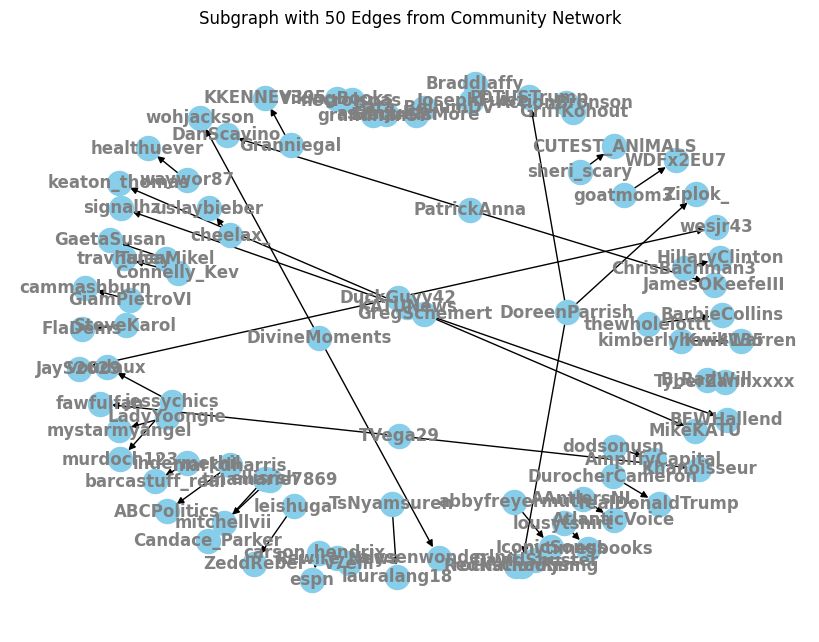

In [123]:
edges_to_draw = list(G.edges())[0:50]
subgraph = G.edge_subgraph(edges_to_draw).copy()

# Draw the subgraph
plt.figure(figsize=(8, 6))
nx.draw(subgraph, with_labels=True, node_size=300, node_color='skyblue', font_size=12, font_color='gray', font_weight='bold', arrowsize=10)
plt.title("Subgraph with 50 Edges from Community Network")
plt.show()

## Girvan Newman subgraphs

In [124]:
def girvan_newman_k_edges(G, K):
    start_time = time.time()
    for _ in range(K):
        betweenness = nx.edge_betweenness_centrality(G)
        edge_to_remove = max(betweenness, key=betweenness.get)
        G.remove_edge(*edge_to_remove)
    end_time = time.time()
    return G, end_time - start_time

K_values = [1,20, 50]
times = {}
subgraphs = []
with parallel_backend("loky", n_jobs=-1):
    for K in K_values:
        G_copy = G.copy()
        subgraph, elapsed_time = girvan_newman_k_edges(G_copy, K)
        subgraphs.append(subgraph)
        times[K] = elapsed_time
        print(f"Time to remove {K} edges: {times[K]:.2f} seconds")


Time to remove 1 edges: 91.25 seconds
Time to remove 20 edges: 1840.69 seconds
Time to remove 50 edges: 4951.26 seconds


In [125]:
for i, sg in enumerate(subgraphs):
    print(f"Subgraph {i+1} has {sg.number_of_nodes()} nodes and {sg.number_of_edges()} edges")


Subgraph 1 has 4482 nodes and 2704 edges
Subgraph 2 has 4482 nodes and 2685 edges
Subgraph 3 has 4482 nodes and 2655 edges


## Subgraph Communities

In [126]:
# Function to detect communities using Girvan-Newman algorithm
def detect_communities(G):
    communities_generator = nx.community.girvan_newman(G)
    top_level_communities = next(communities_generator)
    return [list(community) for community in top_level_communities]

# Assign actual class labels to nodes
actual_labels = {row['user_handle']: row['class'] for _, row in community.iterrows()}

# Analyze each subgraph
for i, subgraph in enumerate(subgraphs):
    print(f"Analyzing community structures in Subgraph {i+1}:")
    
    # Convert subgraph to undirected for community detection
    undirected_subgraph = subgraph.to_undirected()
    
    # Detect communities
    communities = detect_communities(undirected_subgraph)
    
    # Create predicted labels based on detected communities
    predicted_labels = {}
    for community_id, community in enumerate(communities):
        for node in community:
            predicted_labels[node] = community_id
    
    # Only include nodes present in both actual and predicted labels
    common_nodes = set(actual_labels.keys()).intersection(predicted_labels.keys())
    actual = [actual_labels[node] for node in common_nodes]
    predicted = [predicted_labels[node] for node in common_nodes]
    
    # Calculate NMI
    
    nmi = normalized_mutual_info_score(actual, predicted)
    
    print(f"Subgraph {i+1} - Normalized Mutual Information: {nmi:.4f}\n")

Analyzing community structures in Subgraph 1:
Subgraph 1 - Normalized Mutual Information: 0.1675

Analyzing community structures in Subgraph 2:
Subgraph 2 - Normalized Mutual Information: 0.1676

Analyzing community structures in Subgraph 3:
Subgraph 3 - Normalized Mutual Information: 0.1673



## Subgraph Pagerank and HITS Evalution

In [127]:
for i, sg in enumerate(subgraphs):
    print(f"Subgraph {i+1}:")

    # Calculate PageRank
    pagerank_scores = nx.pagerank(sg)
    sorted_pagerank = sorted(
        pagerank_scores.items(), key=lambda item: item[1], reverse=True
    )
    print("\nTop 10 nodes by PageRank:\n")
    for node, score in sorted_pagerank[:10]:
        print(f"Node {node}: {score}")

    # Calculate HITS
    hits_scores = nx.hits(sg)
    hubs_scores, authorities_scores = hits_scores
    sorted_hubs = sorted(hubs_scores.items(), key=lambda item: item[1], reverse=True)
    sorted_authorities = sorted(
        authorities_scores.items(), key=lambda item: item[1], reverse=True
    )

    print("\nTop 10 nodes by HITS - Hubs:\n")
    for node, score in sorted_hubs[:10]:
        print(f"Node {node}: {score}")

    print("\nTop 10 nodes by HITS - Authorities:\n")
    for node, score in sorted_authorities[:10]:
        print(f"Node {node}: {score}")

    print("\n" + "=" * 50 + "\n")

Subgraph 1:

Top 10 nodes by PageRank:

Node realDonaldTrump: 0.004338511170142968
Node FoxNews: 0.00262070255301124
Node HillaryClinton: 0.002315551195301375
Node wikileaks: 0.0022675930924495264
Node mitchellvii: 0.0020823004223401134
Node WDFx2EU7: 0.001668116806801425
Node PrisonPlanet: 0.0016572172379714595
Node JoyAnnReid: 0.0016245185314815631
Node SportsCenter: 0.0012648327600927023
Node LouDobbs: 0.0012430336224327715

Top 10 nodes by HITS - Hubs:

Node tjoffner: 0.029659160507579732
Node ProcessCivil: 0.028845571411430404
Node LPhillipsDesign: 0.028765704219530976
Node Lukeinf86: 0.028013440290999433
Node mlmook: 0.027875505507085983
Node DurocherCameron: 0.027085505751197735
Node jeannieaburris: 0.027085505751197735
Node Brian_Larry2u: 0.027085505751197735
Node cdcook: 0.027085505751197735
Node SonaMetz: 0.027085505751197735

Top 10 nodes by HITS - Authorities:

Node realDonaldTrump: 0.76805138884406
Node wikileaks: 0.04914489174015663
Node asamjulian: 0.026313018431252635
N